In [ ]:
# If not installed, run this cell. It is needed for access to GEE
#!pip install earthengine-api
#!pip show ee

In [178]:
# If not installed, run this cell. It helps visualization of data
#!pip install geemap
#!pip show geemap

In [179]:
# Import libraries
import ee, pandas as pd, geemap, ipyleaflet, ipywidgets as widgets, matplotlib.pyplot as plt
import calendar
# from IPython.display import Image
from otherfunctions import water_balance, ee_array_to_df, determine_period
from functools import partial

In [180]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jvg')

In [ ]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
hydrobasins = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_3')
hybas_id = "HYBAS_ID"
Map = geemap.Map()
Map.addLayer(hydrobasins, {}, 'HydroBasins')

In [182]:
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = ipyleaflet.WidgetControl(widget=output_widget, position="bottomright")
Map.add_control(output_control)

In [183]:
# This ID and lat and lon will be identified through the interative map above by clicking on the basin of your interest.
# See the widget on the bottom right side of the map
# Define the basin and location of interest
selected_basin_id = None
lat = None
lon = None

def remove_layer(pre_name):
    layer_names = Map.layers # Get the list of layer names
    layers = Map.layers[:]  # Get the list of layers
    names = [layer.name for layer in layer_names]  # Extract layer names

    for item in names:
        if pre_name in item: # Check if the name is in the item
            index = names.index(item)  # Get the index of the name
            layer = layer_names[index]  # Retrieve the layer at the index
            Map.remove(layer)  # Remove the layer from the map    
            return Map.layers[:]
  
    return layers

# Function to identify the ID of the basin of interest by clicking on the map over the feature of the HydroSHEDS
def handle_interaction(**kwargs):
    global selected_basin_id, lat, lon, poi, poi_ft

    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        lat = latlon[0]
        lon = latlon[1]
        xy = ee.Geometry.Point(latlon[::-1])
        selected_fc = hydrobasins.filterBounds(xy)

        # The point location was previously defined by clicking on the map
        poi = ee.Geometry.Point(lon, lat)
        poi_ft = ee.FeatureCollection(ee.Geometry.Point(lon, lat))
        Map.addLayer(poi_ft, {'color': 'green', 'pointSize': 10}, "Point of Interest")

        with output_widget:
            output_widget.clear_output()

            try:
                pre_name = "Identified Basin: "
                Map.layers = remove_layer(pre_name)
                selected_basin_id = selected_fc.first().get(hybas_id).getInfo()
                geom = selected_fc.geometry()
                layer_name = pre_name + str(selected_basin_id)
                Map.centerObject(geom)
                Map.addLayer(ee.Image().paint(geom, 0, 2), {'palette': 'red'}, layer_name)                
                print(layer_name + "\nLat: " + str(lat) + " Long: " + str(lon))
            except Exception as e:
                print('No feature could be found')
                Map.layers = Map.layers[:]

        Map.default_style = {'cursor': 'pointer'}

Map.on_interaction(handle_interaction)
Map.default_style = {'cursor': 'pointer'}
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [184]:
## Initial parameters ##

# It is recommended using at least 5 years of equilibration period - warm up years. This allows the model to get the water cycling properly.
# When a proper equilibration (warm-up) period is incorporated, "ffcb" value is not going to impact model results
warmup_yrs = 5
start_date = '2008-01'
end_date = '2023-12'
ini_date, fin_date = determine_period(start_date, end_date, warmup_yrs)

Simulation period will be from 2008-01 to 2023-12 (192 months); however, outputs will be provided for 2013-01 to 2023-12 (132 months)


In [185]:
######################################################
### Starting values for the water balance model - T&M
######################################################

# Initial soil water storage expressed as a fraction of water holding capacity [0-1]
ffcb = 0.1 # 10%

# Base flow of the previous month (mm)
bflow_ant = 10

In [186]:
raise SystemExit("Please go to the interactive map and click on the basin and point of interest before continuing running the cells below!")

SystemExit: Please go to the interactive map and click on the basin and point of interest before continuing running the cells below!

In [187]:
# Public link to the asset whc: https://code.earthengine.google.com/?asset=projects/ee-jvg/assets/world_water_balance/whc_fc33
zoi = hydrobasins.select(hybas_id).filter(ee.Filter.eq(hybas_id, selected_basin_id))
whc = ee.Image('projects/ee-jvg/assets/world_water_balance/whc_fc33')
whc = whc.clip(zoi).divide(1000) # As the raster was originally multiplied by 1000
whc = whc.where(whc.eq(0), 1/1000000) # Avoid division by zero in subsequent calculations (sstor)
Map.addLayer(whc, {
  'min': 0,
  'max': 1000,
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ]
  },
  'Water Holding Capacity')

In [188]:
# TerraClimate layers filtered with "start_date" (inclusive) and "end_date" (exclusive) and to "zoi"
bands = ["pr", "pet", "ro"]
terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').select(bands).filterBounds(zoi).filter(ee.Filter.date(start_date, fin_date))

In [189]:
######################################################
# Initial images and time to start the water balance
######################################################

# Public link to the asset whc: https://code.earthengine.google.com/?asset=projects/ee-jvg/assets/world_water_balance/monthly_k_recession_constant
# The recession constant (k) was determined from hydrographs derived from the gathered streamflow datasets. For the rest of the world, k was defined as 0.5
k = ee.Image('projects/ee-jvg/assets/world_water_balance/monthly_k_recession_constant') # Image of recession constant
k = k.clip(zoi).divide(10000) # As the raster was originally multiplied by 10000
st0 = whc.multiply(ffcb) # Initial soil water storage
bf0 = ee.Image(bflow_ant) # Previous baseflow
time0 = terraclimate.first().get("system:time_start") # Define the initial time (time0) according to the start of the collection
scale = terraclimate.first().projection().nominalScale() # This is the resolution used to standardize
crs = 'EPSG:3857' # WGS 84 / Pseudo-Mercator -- Spherical Mercator, Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI

# Water balance variables
wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]

In [190]:
# Initialization of ALL bands.
# Mandatory to cast the type of the data with a .float().

# Initialization of precipitation
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

# Initialization of runoff
initial_ro = ee.Image(0).set("system:time_start", time0).select([0], ["ro"]).float()

# Initialization of effective precipitation
initial_ep = ee.Image(0).set("system:time_start", time0).select([0], ["eprec"]).float()

# Initialization of actual evapotranspiration
initial_aet = ee.Image(0).set("system:time_start", time0).select([0], ["aet"]).float()

# Initialization of soil storage, which is considered to be a fraction of WCH
initial_st = st0.set("system:time_start", time0).select([0], ["sstor"]).float()

# Initialization of percolation
initial_pc = ee.Image(0).set("system:time_start", time0).select([0], ["perc"]).float()

# Initialization of base flow, which is considered as defined in Ulmen (2000)
initial_bf = bf0.set("system:time_start", time0).select([0], ["bflow"]).float()

# Initialization of water yield
initial_wy = ee.Image(0).set("system:time_start", time0).select([0], ["wyield"]).float()

In [191]:
# All initial bands are combined into one "ee.Image" by adding them to the first band (wy)
initial_image = initial_wy.addBands(
    ee.Image([initial_pr, initial_pet, initial_ro, initial_ep, initial_aet, initial_st, initial_pc, initial_bf])
)

# Initiatlization of list that will contain new images after each iteration
image_list = ee.List([initial_image])

In [192]:
#########################
# WATER BALANCE EXECUTION
#########################

partial_function = partial(water_balance, ee = ee, whc = whc, k = k)

# Iterate the user-supplied function to the terraclimate collection
wy_list = terraclimate.iterate(partial_function, image_list)

# Remove the initial image from our list
wy_list = ee.List(wy_list).remove(initial_image)

# Transform the list into an ee.ImageCollection
wy_coll = ee.ImageCollection(wy_list).filter(ee.Filter.date(ini_date, fin_date))

In [193]:
# Let's assign year and month to each image of the resulting image collection
wy_coll = wy_coll.map(lambda image: image.set("year", ee.Image(image).date().get("year")))
wy_coll = wy_coll.map(lambda image: image.set("month", ee.Image(image).date().get("month")))

In [194]:
# Let's have a look at the results around a location of interest
# WARNING: It crashes if the number of simulation years is greater than 11 on a monthly basis, i.e., more than 132 images.
# It will result in a df that includes data from all the reporting/printing timeperiod
arr = wy_coll.getRegion(poi, scale).getInfo()
rdf = ee_array_to_df(arr, wb_vars).sort_index()
rdf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
2013-01,1356998400000,292,65.6,226,66,65.600000,25.474000,0.400000,11.526319,237.526319
2013-02,1359676800000,297,70.4,227,70,69.603124,25.077124,0.000000,5.763160,232.763160
2013-03,1362096000000,245,73.0,172,73,73.000000,25.077124,0.000000,2.881580,174.881580
2013-04,1364774400000,142,84.0,58,84,84.000000,25.077124,0.000000,1.440790,59.440790
2013-05,1367366400000,173,78.2,95,78,77.803887,24.881011,0.000000,0.720395,95.720395
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,27,114.7,1,26,25.844558,0.004931,0.000000,0.094334,1.094334
2023-09,1693526400000,30,122.5,2,28,27.995190,0.000121,0.000000,0.047167,2.047167
2023-10,1696118400000,50,122.7,3,47,46.999885,0.000006,0.000000,0.023584,3.023584


In [195]:
# Get values of initial variables for the point of interest
copy_ii = initial_image.set('system:time_start', 0)
intial_imgs = ee.ImageCollection(ee.List([copy_ii]))
initial_arr = intial_imgs.getRegion(poi, scale).getInfo()
idf = ee_array_to_df(initial_arr, wb_vars).sort_index()
idf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0,0,0,0,2.5474,0,10,0


In [196]:
# This process is carried out to validate whether the water balance outputs were correctly calculated. Verification was done by other means
# Therefore, only if a warm-up period was not defined, this could be useful. On the contrary, the datetime of the initial variables dataframe ("idf") will not meet the antecedent datetime of dataframe "rdf"
rdff = pd.concat([idf, rdf])
#rdf.to_excel("D:\Borrar\wb_point.xlsx")
#rdff.to_csv("D:\Borrar\wb_point.csv")
rdff

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0.0,0,0,0.000000,2.547400,0.000000,10.000000,0.000000
2013-01,1356998400000,292,65.6,226,66,65.600000,25.474000,0.400000,11.526319,237.526319
2013-02,1359676800000,297,70.4,227,70,69.603124,25.077124,0.000000,5.763160,232.763160
2013-03,1362096000000,245,73.0,172,73,73.000000,25.077124,0.000000,2.881580,174.881580
2013-04,1364774400000,142,84.0,58,84,84.000000,25.077124,0.000000,1.440790,59.440790
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,27,114.7,1,26,25.844558,0.004931,0.000000,0.094334,1.094334
2023-09,1693526400000,30,122.5,2,28,27.995190,0.000121,0.000000,0.047167,2.047167
2023-10,1696118400000,50,122.7,3,47,46.999885,0.000006,0.000000,0.023584,3.023584


In [197]:
# Preparing dataframe for chart visualization
new_pd = rdf.drop(["time"], axis=1)
new_pd["year"] = rdf.apply(lambda row: row.name.split("-")[0], axis=1)
new_pd["month"] = new_pd.apply(lambda row: calendar.month_abbr[int(row.name.split("-")[1])], axis=1)
new_pd

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield,year,month
datetime,,,,,,,,,,,
2013-01,292,65.6,226,66,65.600000,25.474000,0.400000,11.526319,237.526319,2013,Jan
2013-02,297,70.4,227,70,69.603124,25.077124,0.000000,5.763160,232.763160,2013,Feb
2013-03,245,73.0,172,73,73.000000,25.077124,0.000000,2.881580,174.881580,2013,Mar
2013-04,142,84.0,58,84,84.000000,25.077124,0.000000,1.440790,59.440790,2013,Apr
2013-05,173,78.2,95,78,77.803887,24.881011,0.000000,0.720395,95.720395,2013,May
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,27,114.7,1,26,25.844558,0.004931,0.000000,0.094334,1.094334,2023,Aug
2023-09,30,122.5,2,28,27.995190,0.000121,0.000000,0.047167,2.047167,2023,Sep
2023-10,50,122.7,3,47,46.999885,0.000006,0.000000,0.023584,3.023584,2023,Oct


In [198]:
# Annual values
pd_yr = new_pd.drop("month", axis=1).groupby(["year"]).sum()
pd_yr

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
year,,,,,,,,,
2013,1764,998.9,852,912,776.272509,215.239719,50.672509,50.467781,902.467781
2014,2162,999.7,1235,927,791.953837,164.810706,82.953837,68.979545,1303.979545
2015,1653,1031.2,848,805,705.761781,140.951065,24.825625,61.601267,909.601267
2016,2172,1023.3,1107,1065,847.208099,217.044051,140.834725,131.518606,1238.518606
2017,2219,1022.7,1265,954,837.393172,214.857704,63.597827,62.257091,1327.257091
2018,2244,939.4,1366,878,765.704252,214.982458,60.508931,62.780076,1428.780076
2019,2697,1003.6,1783,914,778.235956,212.343859,84.736152,82.358822,1865.358822
2020,2147,1111.8,1167,980,817.328458,199.584240,110.626699,93.786438,1260.786438
2021,2341,1082.2,1406,935,761.626237,206.582870,122.127997,123.351938,1529.351938


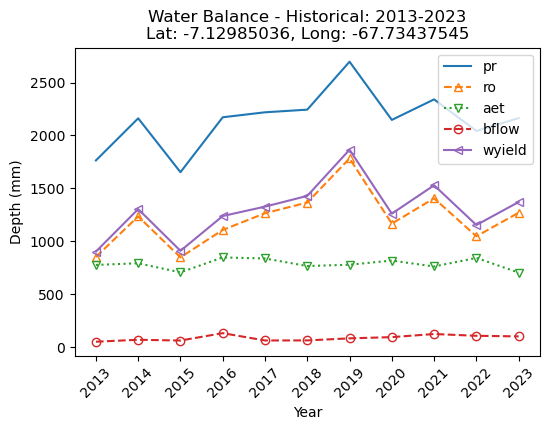

In [199]:
# Plot of yearly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_yr.drop(["pet", "eprec", "sstor", "perc"], axis=1).columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_yr[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [200]:
# Monthly values
pd_month = new_pd.drop("year", axis=1).groupby(["month"], sort=False).mean()
pd_month

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
month,,,,,,,,,
Jan,337.363636,75.036364,251.636364,85.727273,74.873525,25.366573,8.340272,13.187191,264.823555
Feb,321.363636,69.490909,251.909091,69.454545,69.220766,25.232793,0.100000,6.643595,258.552686
Mar,284.000000,77.809091,213.090909,70.909091,68.450354,22.937408,0.091193,3.367394,216.458303
Apr,232.818182,76.427273,152.000000,80.818182,76.177552,25.067176,2.265966,2.816680,154.816680
May,179.000000,81.418182,97.545455,81.454545,81.041483,25.006128,0.102531,1.459606,99.005060
Jun,74.909091,84.509091,8.272727,66.636364,55.287303,13.711612,0.000000,0.729803,9.002530
Jul,41.545455,101.836364,2.090909,39.454545,28.034775,2.291842,0.000000,0.364901,2.455811
Aug,39.727273,109.627273,1.909091,37.818182,35.755506,0.229166,0.000000,0.182451,2.091542
Sep,66.454545,106.718182,3.272727,63.181818,63.038285,0.085633,0.000000,0.091225,3.363953


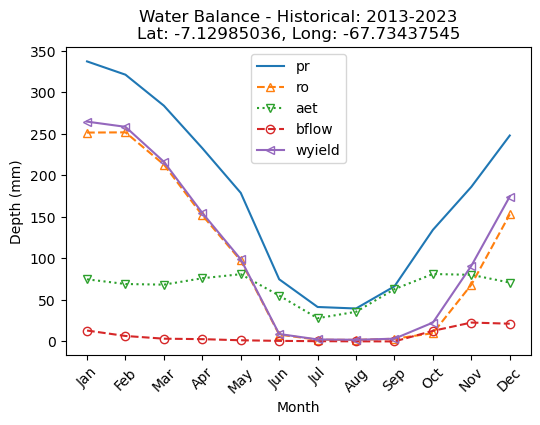

In [201]:
# Plot of monthly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_month.drop(["pet", "eprec", "sstor", "perc"], axis=1).columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-"]
markers = ["", "^", "v", "o", "<"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_month[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [202]:
def create_annual_composite(year):
  # Reduce image collection for the year
  annual_image = ee.ImageCollection(wy_coll.select(wb_vars) \
                          .filterMetadata('year', 'equals', year) \
                          .set('year', year)).sum().float()

  # Rename bands with original names
  annual_image = annual_image.rename(ee.List(wb_vars))

  return annual_image

# Define years from image collection
years = ee.List(wy_coll.aggregate_array('year')).distinct().sort()

# Create annual image collection
annual_ic = ee.ImageCollection.fromImages(years.map(lambda year: create_annual_composite(ee.Number(year))))

In [203]:
var_to_show = "ro" # wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
img_to_show = annual_ic.select(var_to_show).map(lambda image: image.clip(zoi))

# Define arguments for the getVideoThumbURL function parameters to get an adequate video thumbnail
videoArgs = {
  "dimensions": 768,
  "region": zoi.geometry(),
  "framesPerSecond": 3,
  "crs": crs,
  "min": 1000, # Change this value as needed
  "max": 4000, # Change this value as needed
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ],
}

# Get the video thumbnail URL for the temperature image collection
video_url = img_to_show.getVideoThumbURL(videoArgs)
print("Video Thumbnail URL: ", video_url)

Video Thumbnail URL:  https://earthengine.googleapis.com/v1/projects/ee-jvg/videoThumbnails/459c4706ba2c98786257ff67790472e3-4e67c310127ced6a60e178deff46f85c:getPixels


In [204]:
# Let's have a look at the results around a location of interest by using the aggregated image collection on a yearly basis:
annual_arr = annual_ic.getRegion(poi, scale).getInfo()
annual_rdf = ee_array_to_df(annual_arr, wb_vars).reset_index(drop=True).drop(["time"], axis=1)
annual_rdf["year"] = years.getInfo()
annual_rdf = annual_rdf.set_index("year")
annual_rdf

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
year,,,,,,,,,
2013,1764,998.900024,852,912,776.272522,215.239716,50.672508,50.467781,902.467773
2014,2162,999.700012,1235,927,791.953857,164.810699,82.953835,68.979546,1303.979492
2015,1653,1031.199951,848,805,705.761780,140.951065,24.825624,61.601269,909.601257
2016,2172,1023.299988,1107,1065,847.208069,217.044052,140.834732,131.518600,1238.518555
2017,2219,1022.700012,1265,954,837.393188,214.857697,63.597828,62.257092,1327.257080
2018,2244,939.400024,1366,878,765.704224,214.982452,60.508930,62.780075,1428.780029
2019,2697,1003.599976,1783,914,778.235962,212.343857,84.736153,82.358818,1865.358765
2020,2147,1111.800049,1167,980,817.328430,199.584244,110.626701,93.786438,1260.786499
2021,2341,1082.199951,1406,935,761.626221,206.582870,122.127998,123.351936,1529.351929


In [205]:
def create_monthly_composite(month):
  # Reduce image collection for the year
  monthly_image = ee.ImageCollection(wy_coll.select(wb_vars) \
                          .filterMetadata('month', 'equals', month) \
                          .set('month', month)).mean().float()

  # Rename bands with original names
  monthly_image = monthly_image.rename(ee.List(wb_vars))

  return monthly_image

# Define months from image collection
months = ee.List(wy_coll.aggregate_array('month')).distinct().sort()

# Create annual image collection
monthly_ic = ee.ImageCollection.fromImages(months.map(lambda month: create_monthly_composite(ee.Number(month))))

In [206]:
var_to_show2 = "ro" # wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
img_to_show2 = monthly_ic.select(var_to_show2).map(lambda image: image.clip(zoi))

# Define arguments for the getVideoThumbURL function parameters to get an adequate video thumbnail
videoArgs2 = {
  "dimensions": 768,
  "region": zoi.geometry(),
  "framesPerSecond": 3,
  "crs": crs,
  "min": 0, # Change this value as needed
  "max": 400, # Change this value as needed
  'palette': [
      '#AFEEEE',
      '#E0FFFF',
      '#00FFFF',
      '#87CEEB',
      '#000080'
  ],
}

# Get the video thumbnail URL for the temperature image collection
video_url2 = img_to_show2.getVideoThumbURL(videoArgs2)
print("Video Thumbnail URL: ", video_url2)

Video Thumbnail URL:  https://earthengine.googleapis.com/v1/projects/ee-jvg/videoThumbnails/3b3da9706b3d6f3c59ec38d937187ee7-a92a47957d2b0fbd6bf28b3d0b6e8b2f:getPixels


In [207]:
# Let's have a look at the results around a location of interest by using the aggregated image collection on a monthly basis:
monthly_arr = monthly_ic.getRegion(poi, scale).getInfo()
monthly_rdf = ee_array_to_df(monthly_arr, wb_vars).reset_index(drop=True).drop(["time"], axis=1)
monthly_rdf["month"] = months.getInfo()
monthly_rdf["month"] = monthly_rdf["month"].apply(lambda row: calendar.month_abbr[row])
monthly_rdf = monthly_rdf.set_index("month")
monthly_rdf

,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
month,,,,,,,,,
Jan,337.363647,75.036362,251.636368,85.727272,74.873528,25.366573,8.340272,13.187191,264.823547
Feb,321.363647,69.490906,251.909088,69.454544,69.220764,25.232794,0.100000,6.643596,258.552673
Mar,284.000000,77.809090,213.090912,70.909088,68.450356,22.937408,0.091193,3.367394,216.458298
Apr,232.818176,76.427269,152.000000,80.818184,76.177551,25.067177,2.265966,2.816680,154.816681
May,179.000000,81.418182,97.545456,81.454544,81.041481,25.006128,0.102531,1.459606,99.005058
Jun,74.909088,84.509094,8.272727,66.636360,55.287304,13.711612,0.000000,0.729803,9.002530
Jul,41.545456,101.836365,2.090909,39.454544,28.034775,2.291842,0.000000,0.364901,2.455811
Aug,39.727272,109.627274,1.909091,37.818180,35.755505,0.229166,0.000000,0.182451,2.091542
Sep,66.454544,106.718185,3.272727,63.181820,63.038284,0.085633,0.000000,0.091225,3.363953
